In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm
from scour_hazard import LHS_scour_hazard, combine_simulated_samples  # Ensure scour_hazard.py is in your PYTHONPATH or current directory

In [2]:
# Number of Latin Hypercube Samples
lhsN = 1000

# Define three different parameter scenarios
scenarios = [
    {
        'name': 'Scenario 3: Missouri River',
        'params': {'lhsN': lhsN, 'vel': 2.9, 'dPier': 1, 'gama': 1e-6, 'zDot': 100}
    },
    {
        'name': 'Scenario 2: Colorado River',
        'params': {'lhsN': lhsN, 'vel': 6.5, 'dPier': 1, 'gama': 1e-6, 'zDot': 500}
    },
    {
        'name': 'Scenario 3: Extreme Case',
        'params': {'lhsN': lhsN, 'vel': 10.0, 'dPier': 1, 'gama': 1e-6, 'zDot': 1000}
    }
]

In [3]:

# Prepare lists to store outputs for plotting
hazard_curves = []   # Will store tuples: (name, sorted z50Final, exceedance probability)
histogram_data = []   # Will store tuples: (name, z50Final, logMean, logStd)
simulation_results = [] # Will store all results

# Run the simulation for each scenario
for scenario in scenarios:
    res = LHS_scour_hazard(**scenario['params'])
    # For hazard curves: use sorted scour depths and compute probability of exceedance as (1 - CDF)
    hazard_curves.append((scenario['name'], res['z50Final_sort'], 1 - res['zP']))
    # For histograms: store the raw data and the fitted lognormal parameters
    histogram_data.append((scenario['name'], res['z50Final'], res['z50LogMean'], res['z50LogStd']))
    # Combine all simulation results
    simulation_results.append(res)

# Combine the simulated samples from all scenarios
combined_results = combine_simulated_samples(simulation_results)

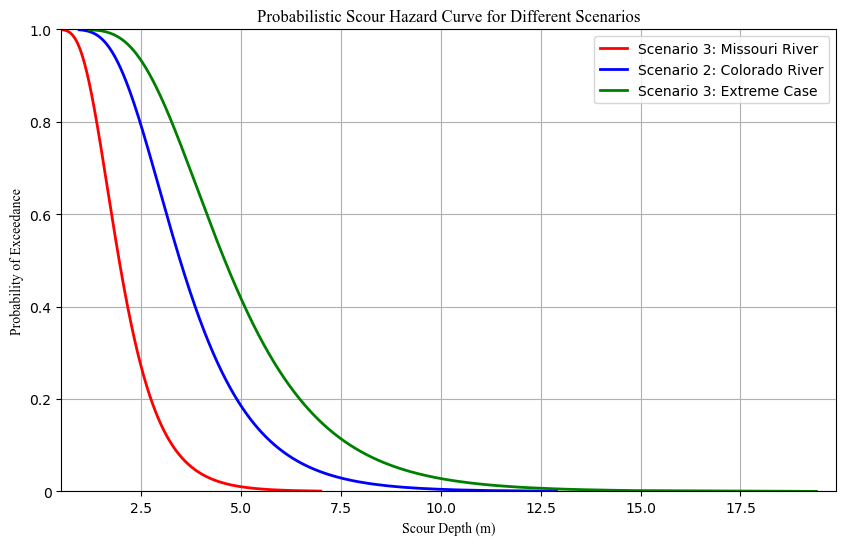

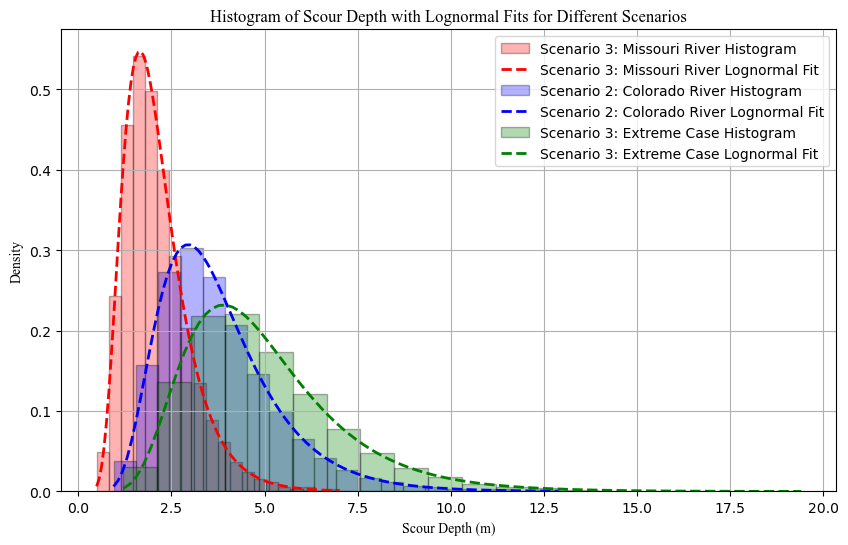

In [4]:
# Define colors for the three scenarios
colors = ['red', 'blue', 'green']


# -------------------------------
# Plot 1: Probabilistic Scour Hazard Curve for all scenarios
plt.figure(figsize=(10, 6))
for i, (name, z50_sorted, exceedance) in enumerate(hazard_curves):
    plt.plot(z50_sorted, exceedance, color=colors[i], linewidth=2, label=name)
plt.xlim([0.5, max([max(z) for _, z, _ in hazard_curves]) + 0.5])
plt.ylim([0, 0.98])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ['0', '0.2', '0.4', '0.6', '0.8', '1.0'])
plt.xlabel('Scour Depth (m)', fontsize=10, fontname='Times New Roman')
plt.ylabel('Probability of Exceedance', fontsize=10, fontname='Times New Roman')
plt.title('Probabilistic Scour Hazard Curve for Different Scenarios', fontsize=12, fontname='Times New Roman')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# Plot 2: Histograms with Lognormal Fits for all scenarios
plt.figure(figsize=(10, 6))
for i, (name, z50Final, logMean, logStd) in enumerate(histogram_data):
    # Plot histogram with density normalization
    plt.hist(z50Final, bins=20, density=True, alpha=0.3, edgecolor='black',
             color=colors[i], label=f'{name} Histogram')
    # Generate x-values over the range of z50Final
    x_min, x_max = np.min(z50Final), np.max(z50Final)
    x_vals = np.linspace(x_min, x_max, 100)
    # Compute the lognormal PDF using scipy: shape parameter = logStd, scale = exp(logMean)
    pdf = lognorm.pdf(x_vals, s=logStd, scale=np.exp(logMean))
    plt.plot(x_vals, pdf, '--', linewidth=2, color=colors[i], label=f'{name} Lognormal Fit')
plt.xlabel('Scour Depth (m)', fontsize=10, fontname='Times New Roman')
plt.ylabel('Density', fontsize=10, fontname='Times New Roman')
plt.title('Histogram of Scour Depth with Lognormal Fits for Different Scenarios', fontsize=12, fontname='Times New Roman')
plt.legend()
plt.grid(True)
plt.show()


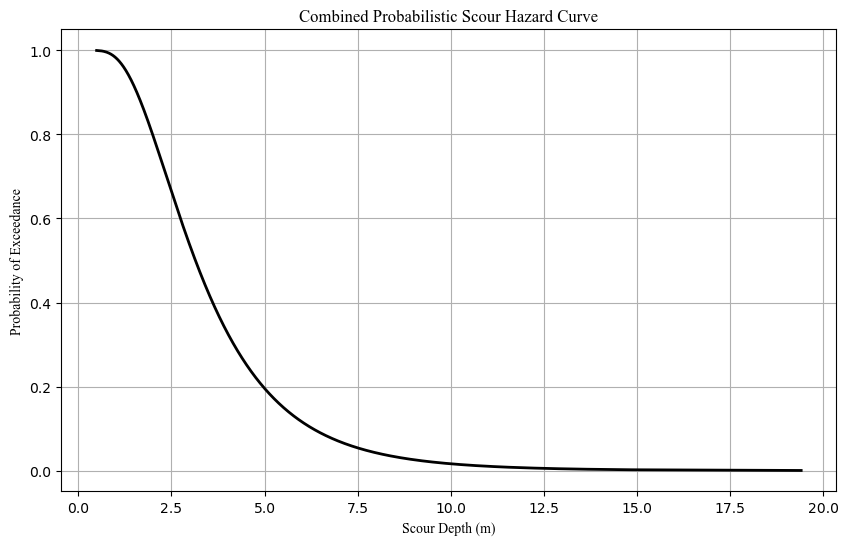

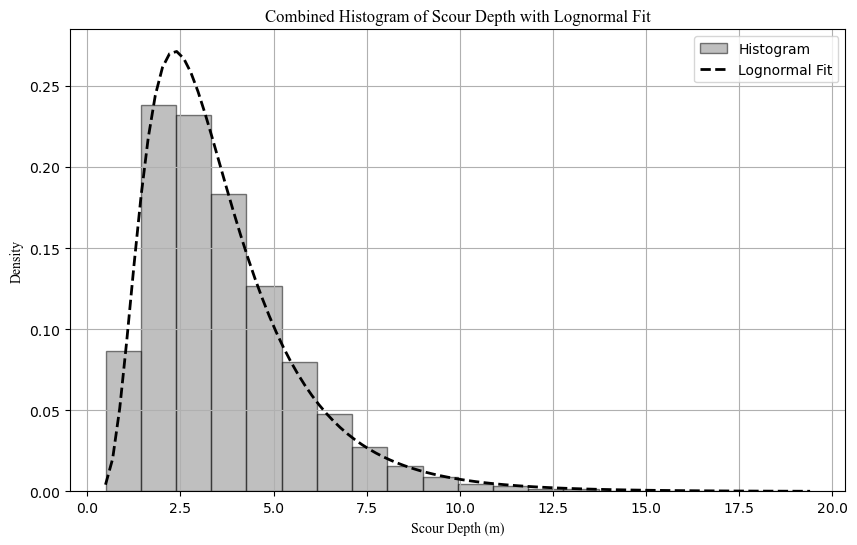

In [5]:
# -------------------------------
# Plot 1: Combined Probabilistic Scour Hazard Curve
plt.figure(figsize=(10, 6))
# Plot hazard curve using sorted combined samples and probability of exceedance (1 - CDF)
plt.plot(combined_results['z50Final_sort'], 1 - combined_results['zP'], '-k', linewidth=2)
plt.xlabel('Scour Depth (m)', fontsize=10, fontname='Times New Roman')
plt.ylabel('Probability of Exceedance', fontsize=10, fontname='Times New Roman')
plt.title('Combined Probabilistic Scour Hazard Curve', fontsize=12, fontname='Times New Roman')
plt.grid(True)
plt.show()

# -------------------------------
# Plot 2: Combined Histogram with Lognormal Fit
plt.figure(figsize=(10, 6))
combined_z50Final = combined_results['z50Final']
# Plot normalized histogram
plt.hist(combined_z50Final, bins=20, density=True, alpha=0.5, color='gray', edgecolor='black', label='Histogram')
# Generate x-values over the range of the combined data
x_vals = np.linspace(np.min(combined_z50Final), np.max(combined_z50Final), 100)
# Compute the fitted lognormal PDF using the combined lognormal parameters
pdf_vals = lognorm.pdf(x_vals, s=combined_results['z50LogStd'], scale=np.exp(combined_results['z50LogMean']))
plt.plot(x_vals, pdf_vals, 'k--', linewidth=2, label='Lognormal Fit')
plt.xlabel('Scour Depth (m)', fontsize=10, fontname='Times New Roman')
plt.ylabel('Density', fontsize=10, fontname='Times New Roman')
plt.title('Combined Histogram of Scour Depth with Lognormal Fit', fontsize=12, fontname='Times New Roman')
plt.legend()
plt.grid(True)
plt.show()


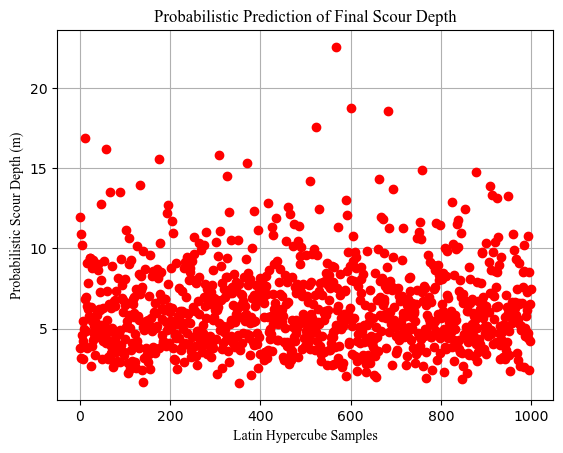

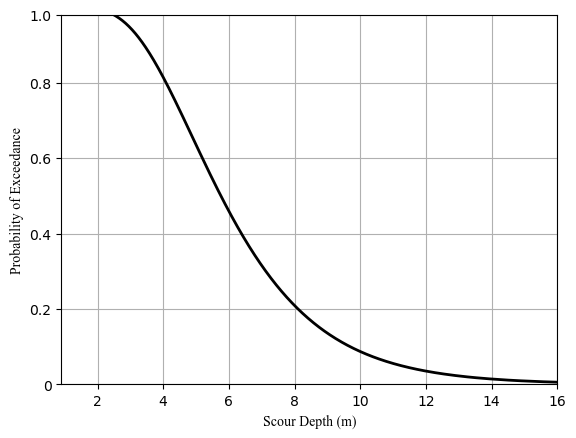

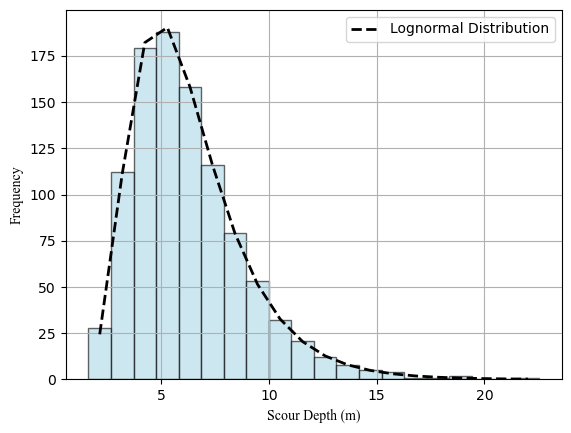

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm

def LHS_scour_hazard(lhsN, vel=10, dPier=2, gama=1e-6, zDot=8, Rey=None):
    """
    Computes the final scour depth (z50Final) using Latin Hypercube Sampling.
    
    Parameters:
        lhsN (int): Number of Latin Hypercube Samples.
        vel (float): Upstream velocity (m/s). Default is 10.
        dPier (float): Diameter of the pier (m). Default is 2.
        gama (float): Water viscosity. Default is 1e-6.
        zDot (float): Initial rate of scour (N/mm). Default is 8.
        Rey (float or None): Reynolds number. If None, computed as (vel * dPier / gama).
        
    Returns:
        results (dict): A dictionary containing computed variables including:
            - z50Final: Final scour depths (in m)
            - z50Final_sort: Sorted final scour depths (in m)
            - zP: Lognormal CDF values evaluated at sorted scour depths
            - z50Mean, z50std: Mean and standard deviation of z50Final
            - z50LogMean, z50LogStd: Mean and std of the log-transformed z50Final
            - z50: Intermediate scour depth (in mm) before unit conversion
            - taoMax: Maximum hydraulic shear stress
            - zMax: Maximum scour depth (in mm)
    """
    # Compute Reynolds number if not provided
    if Rey is None:
        Rey = vel * dPier / gama

    roWat = 1000  # Density of water (kg/m^3)

    # Hydraulic shear stress (taoMax) computed but not used later in the program.
    taoMax = 0.094 * roWat * (vel**2) * ((1 / np.log10(Rey)) - 0.1)

    # Maximum scour depth (zMax) in mm
    zMax = 0.18 * (Rey**0.635)

    # Scour depth at 50 years (z50) in mm
    tYear = 50  
    tEq = 73 * (tYear**0.126) * (vel**1.706) * (zDot**-0.2)
    z50 = tEq / (1/zDot + tEq/zMax)

    # Latin Hypercube Sampling:
    # Create a series of probabilities partitioning the unit interval into lhsN segments.
    randp = (np.arange(lhsN) / lhsN) + (np.random.rand(lhsN) / lhsN)
    # Inverse CDF of the standard normal distribution (ppf)
    lhs_err_ = norm.ppf(randp, loc=0, scale=1)
    # Random permutation to further randomize the sample order
    lhs_err = np.random.permutation(lhs_err_)

    # Compute the final scour depth assuming a lognormal distribution.
    # The division by 1000 converts the unit from mm to m.
    z50Final = (np.exp(-0.085) * z50 * np.exp(0.407 * lhs_err)) / 1000

    # Statistical parameters
    z50Mean = np.mean(z50Final)
    z50std = np.std(z50Final)
    z50LogMean = np.mean(np.log(z50Final))
    z50LogStd = np.std(np.log(z50Final))

    # Sort final scour depths for hazard curve
    z50Final_sort = np.sort(z50Final)

    # Compute the cumulative distribution function (CDF) for a lognormal distribution.
    # In scipy's lognorm, the shape parameter s equals sigma and scale=exp(mu)
    zP = lognorm.cdf(z50Final_sort, s=z50LogStd, scale=np.exp(z50LogMean))

    results = {
        'z50Final': z50Final,
        'z50Final_sort': z50Final_sort,
        'zP': zP,
        'z50Mean': z50Mean,
        'z50std': z50std,
        'z50LogMean': z50LogMean,
        'z50LogStd': z50LogStd,
        #'z50': z50,
        #'taoMax': taoMax,
        #'zMax': zMax
    }

    return results


def combine_simulated_samples(simulation_results):
    """
    Combines multiple simulation results from LHS_scour_hazard and calculates overall statistics.

    Parameters:
        simulation_results (list): A list of dictionaries, each returned by LHS_scour_hazard.

    Returns:
        results (dict): A dictionary containing the combined simulation results with the structure:
            - z50Final: Combined array of final scour depths (in m)
            - z50Final_sort: Sorted combined array of final scour depths (in m)
            - zP: Lognormal CDF values evaluated at the sorted combined scour depths
            - z50Mean: Mean of the combined z50Final
            - z50std: Standard deviation of the combined z50Final
            - z50LogMean: Mean of the logarithm of the combined z50Final
            - z50LogStd: Standard deviation of the logarithm of the combined z50Final
    """
    # Concatenate all z50Final arrays from each simulation
    combined_z50 = np.concatenate([sim['z50Final'] for sim in simulation_results])
    # Sort the combined data
    combined_z50_sort = np.sort(combined_z50)
    # Calculate overall statistical parameters
    z50Mean = np.mean(combined_z50)
    z50std = np.std(combined_z50)
    z50LogMean = np.mean(np.log(combined_z50))
    z50LogStd = np.std(np.log(combined_z50))
    # Compute the lognormal CDF for the sorted combined data
    zP = lognorm.cdf(combined_z50_sort, s=z50LogStd, scale=np.exp(z50LogMean))
    
    results = {
        'z50Final': combined_z50,
        'z50Final_sort': combined_z50_sort,
        'zP': zP,
        'z50Mean': z50Mean,
        'z50std': z50std,
        'z50LogMean': z50LogMean,
        'z50LogStd': z50LogStd
    }
    
    return results


if __name__ == '__main__':
    # Number of Latin Hypercube Samples
    lhsN = 1000  # Adjust as needed

    # Call the function using default parameter values
    results = LHS_scour_hazard(lhsN)
    z50Final = results['z50Final']
    z50Final_sort = results['z50Final_sort']
    zP = results['zP']

    # Plot 1: Probabilistic Prediction of Final Scour Depth
    plt.figure()
    plt.plot(z50Final, 'ro')
    plt.title('Probabilistic Prediction of Final Scour Depth', fontsize=12, fontname='Times New Roman')
    plt.ylabel('Probabilistic Scour Depth (m)', fontsize=10, fontname='Times New Roman')
    plt.xlabel('Latin Hypercube Samples', fontsize=10, fontname='Times New Roman')
    plt.grid(True)

    # Plot 2: Probabilistic Scour Hazard Curve
    plt.figure()
    plt.plot(z50Final_sort, 1 - zP, '-k', linewidth=2)
    plt.xlim([0.9, 16])
    plt.ylim([0, 0.98])
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 0.98], ['0', '0.2', '0.4', '0.6', '0.8', '1.0'])
    plt.ylabel('Probability of Exceedance', fontsize=10, fontname='Times New Roman')
    plt.xlabel('Scour Depth (m)', fontsize=10, fontname='Times New Roman')
    plt.grid(True)

    # Plot 3: Histogram with Lognormal Fit
    plt.figure()
    n, bins, patches = plt.hist(z50Final, bins=20, density=False, alpha=0.6,
                                color='lightblue', edgecolor='black')
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    pdf = lognorm.pdf(bin_centers, s=results['z50LogStd'], scale=np.exp(results['z50LogMean']))
    bin_width = bins[1] - bins[0]
    pdf_scaled = pdf * bin_width * lhsN
    plt.plot(bin_centers, pdf_scaled, 'k--', linewidth=2, label='Lognormal Distribution')
    plt.ylabel('Frequency', fontsize=10, fontname='Times New Roman')
    plt.xlabel('Scour Depth (m)', fontsize=10, fontname='Times New Roman')
    plt.legend()
    plt.grid(True)

    plt.show()